In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

### Import Data

In [2]:
df = pd.read_csv(r'.\data\stock_prices_sample.csv')
df = df[df.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']
df.reset_index(drop = True, inplace =True)

### Defining Inputs

In [3]:
TRAIN_SPLIT=700

LOOK_BACK_WINDOW = 180
NUM_OF_FUTURE_PREDICTION = 90


BATCH_SIZE = 256
EPOCHS = 100
EVALUATION_INTERVAL = 20
VALIDATION_INTERVAL = 10

### Data preprocessing

In [4]:
input_features_considered = ["OPEN", "HIGH", "LOW", "CLOSE"]
input_features = df[input_features_considered]
input_data = input_features.values
# normalize the dataset
input_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = input_scaler.fit_transform(input_data)

In [5]:
output_features_considered = ["OPEN", "CLOSE"]
output_features = df[output_features_considered]
target_data = output_features.values
# normalize the dataset
output_scaler = MinMaxScaler(feature_range=(0, 1))
target = output_scaler.fit_transform(target_data)


In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [7]:
x_train, y_train = multivariate_data(dataset=dataset
                                     , target=target
                                     , start_index=0
                                     , end_index=TRAIN_SPLIT
                                     , history_size=LOOK_BACK_WINDOW
                                     , target_size=NUM_OF_FUTURE_PREDICTION)

x_val, y_val = multivariate_data(dataset=dataset
                                 , target=target
                                 , start_index=TRAIN_SPLIT
                                 , end_index=None
                                 , history_size=LOOK_BACK_WINDOW
                                 , target_size=NUM_OF_FUTURE_PREDICTION)

print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape)
print("shape of y_val:", y_val.shape)

shape of x_train: (520, 180, 4)
shape of y_train: (520, 90, 2)
shape of x_val: (25, 180, 4)
shape of y_val: (25, 90, 2)


### RNN LSTM Encoder & Decoder Network

In [8]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=x_train.shape[-2:]))
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[2])))

model.compile(optimizer=RMSprop(clipvalue=1.0), loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Trining

In [9]:
model_history = model.fit(x=x_train, y=y_train
                          , epochs=EPOCHS
                          , validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 520 samples, validate on 25 samples
Epoch 1/100
520/520 [==============================] - 16s 30ms/sample - loss: 0.0238 - val_loss: 0.0433
Epoch 2/100
520/520 [==============================] - 14s 28ms/sample - loss: 0.0097 - val_loss: 0.0329
Epoch 3/100
520/520 [==============================] - 14s 28ms/sample - loss: 0.0106 - val_loss: 0.0175
Epoch 4/100
520/520 [==============================] - 14s 27ms/sample - loss: 0.0104 - val_loss: 0.0595
Epoch 5/100
520/520 [==============================] - 14s 27ms/sample - loss: 0.0089 - val_loss: 0.0378
Epoch 6/100
520/520 [==============================] - 14s 27ms/sample - loss: 0.0118 - val_loss: 0.0443
Epoch 7/100
520/520 [==============================] - 14s 27ms/sample - loss: 0.0087 - val_loss: 0.0595
Epoch 8/100
520/520 [==============================] - 14s 27ms/sample - loss: 0.0084 - val_loss: 0.0228
Epoch 9/100
520/520 [

Epoch 74/100
520/520 [==============================] - 19s 36ms/sample - loss: 0.0050 - val_loss: 0.0146
Epoch 75/100
520/520 [==============================] - 18s 35ms/sample - loss: 0.0075 - val_loss: 0.0321
Epoch 76/100
520/520 [==============================] - 19s 36ms/sample - loss: 0.0053 - val_loss: 0.0363
Epoch 77/100
520/520 [==============================] - 20s 38ms/sample - loss: 0.0050 - val_loss: 0.0342
Epoch 78/100
520/520 [==============================] - 19s 36ms/sample - loss: 0.0049 - val_loss: 0.0768
Epoch 79/100
520/520 [==============================] - 19s 36ms/sample - loss: 0.0053 - val_loss: 0.0424
Epoch 80/100
520/520 [==============================] - 19s 36ms/sample - loss: 0.0045 - val_loss: 0.0877
Epoch 81/100
520/520 [==============================] - 19s 37ms/sample - loss: 0.0052 - val_loss: 0.0578
Epoch 82/100
520/520 [==============================] - 20s 39ms/sample - loss: 0.0052 - val_loss: 0.0451
Epoch 83/100
520/520 [========================

### Train & CV Error (curve by epoch)

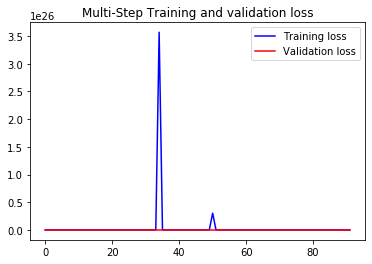

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss'][5:]
    val_loss = history.history['val_loss'][5:]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(model_history, 'Multi-Step Training and validation loss')


### Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               164000    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 90, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 2)             202       
Total params: 505,102
Trainable params: 505,102
Non-trainable params: 0
_________________________________________________________________


### Prediction

In [ ]:
data_predict = dataset[-90:,:]
data_predict = data_predict.reshape((1, data_predict.shape[0], data_predict.shape[1]))
data_extrapolated = output_scaler.inverse_transform(model.predict(data_predict)[0])

In [ ]:
layout = (1,2)
plt.figure(figsize=(17, 8))
plt.subplot2grid(layout, (0,0))
plt.plot(input_data[:,[0,3]], label='training data model')
plt.axis([0, 995, 10, 25])
plt.legend()
plt.grid(True)
plt.title('Actual')
plt.subplot2grid(layout, (0,1))
plt.plot(data_extrapolated, label='testing data model')
plt.title('Forecast')
plt.axis([0, 995, 10, 25])
plt.legend()
plt.grid(True);